In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
sentences = []
stereotypes = []

for line in open('sentences.txt'):
    words = line.split()
    sentences.append(' '.join(words[:-1]))
    stereotypes.append(int(words[-1]))


In [21]:
import re

from translators.amazon_translate import AmazonTranslate
from translators.deepl import DeepL
from translators.google_translate import GoogleTranslate
from translators.chatgpt import ChatGPT

# import logging
# logging.basicConfig()
# logging.getLogger('deepl').setLevel(logging.WARNING)


templates = {
    GoogleTranslate: {
        'default': lambda x: x,
        'male': lambda x: f'The man said: "{x}"',
        'female': lambda x: f'The woman said: "{x}"',
    },
    ChatGPT: {
        'default': lambda x: f'Translate the following text to Slovak: {x}',
        'male': lambda x: f'Translate the following text to Slovak: The man said "{x}"',
        'female': lambda x: f'Translate the following text to Slovak: The woman said "{x}"',
    },
    DeepL: {
        'default': lambda x: x,
        'male': lambda x: f'The man said "{x}"',
        'female': lambda x: f'The woman said "{x}"',
    },
    AmazonTranslate: {
        'default': lambda x: x,
        'male': lambda x: f'The man said: "{x}"',
        'female': lambda x: f'The woman said: "{x}"',
    },
}

patterns = {
    GoogleTranslate: {
        'male': [
            re.compile(r'Muž povedal: "(?P<translation>.*)"'),
            re.compile(r'Muž povedal: „(?P<translation>.*)“'),
            re.compile(r'Muž povedal: (?P<translation>.*)'),
        ],
        'female': [
            re.compile(r'Žena povedala: "(?P<translation>.*)"'),
            re.compile(r'Žena povedala: „(?P<translation>.*)“'),
            re.compile(r'Žena povedala: (?P<translation>.*)'),
        ],
    },
    ChatGPT: {
        'male': [
            re.compile(r'Muž povedal[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Muz povedal[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Muž sa opýtal[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Muž povedal[:,]? „(?P<translation>.*)“[\.]?'),
            re.compile(r'Muž povedal[:,]? „(?P<translation>.*)"[\.]?'),
        ],
        'female': [
            re.compile(r'Žena povedala[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena hovorila[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena sa opýtala[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'žena povedala[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena povedala[:,]? „(?P<translation>.*)“[\.]?'),
            re.compile(r'Žena povedala[:,]? „(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena povedala[:,]? “(?P<translation>.*)”[\.]?'),
            re.compile(r'Žena povedala[:,]? ,,(?P<translation>.*)"[\.]?'),
        ],
    },
    DeepL: {
        'male': [
            re.compile(r'Muž povedal: "(?P<translation>.*)"'),
            re.compile(r'Ten(to)? (muž )?povedal: "(?P<translation>.*)"'),
            re.compile(r'Muž sa opýtal: "(?P<translation>.*)"'),
            re.compile(r'Muž uviedol: "(?P<translation>.*)"'),
            re.compile(r'Povedal: "(?P<translation>.*)"'),
            re.compile(r'"(?P<translation>.*)"'),
        ],
        'female': [
            re.compile(r'Žena povedala: "(?P<translation>.*)"'),
            re.compile(r'Tá(to)? žena povedala: "(?P<translation>.*)"'),
            re.compile(r'Žena sa [os]?pýtala: "(?P<translation>.*)"'),
            re.compile(r'Žena uviedla: "(?P<translation>.*)"'),
            re.compile(r'"(?P<translation>.*)" opýtala sa žena.'),
            re.compile(r'"(?P<translation>.*)"'),
        ],
    },
    AmazonTranslate: {
        'male': [
            re.compile(r'Muž (od)?povedal: „(?P<translation>.*)“'),
        ],
        'female': [
            re.compile(r'Žena (od)?povedala: „(?P<translation>.*)“'),
        ],
    },
}


In [22]:
import logging
from functools import lru_cache

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@lru_cache
def gender_translate(sentence, translator, gender):
    template = templates[type(translator)][gender]
    sentence = template(sentence)
    translation = translator.translate([sentence])[sentence].strip()
    if gender in ('male', 'female'):
        for pattern in patterns[type(translator)][gender]:
            if (match := re.fullmatch(pattern, translation)):
                translation = match.group('translation')
                break
        else:
            logger.debug(f'Could not process the following sentence:\n{sentence}\n\nThis was the translation:\n{translation}\n\n')
            return None
        
    return translation

deepl = DeepL(data_path='./cache/deepl', enable_api=False, server_url='https://api.deepl.com').load()
chatgpt = ChatGPT(data_path='./cache/chatgpt', enable_api=False).load()
google_translate = GoogleTranslate(data_path='./cache/google_translate', enable_api=False).load()
amazon_translate = AmazonTranslate(data_path='./cache/amazon_translate', enable_api=False).load()
translators = (deepl, google_translate, amazon_translate)

(
gender_translate(sentences[1], chatgpt, 'default'),
gender_translate(sentences[1], chatgpt, 'male'),
gender_translate(sentences[1], chatgpt, 'female'),
gender_translate(sentences[1], deepl, 'default'),
gender_translate(sentences[1], deepl, 'male'),
gender_translate(sentences[1], deepl, 'female'),
gender_translate(sentences[1], google_translate, 'default'),
gender_translate(sentences[1], google_translate, 'male'),
gender_translate(sentences[1], google_translate, 'female'),
gender_translate(sentences[1], amazon_translate, 'default'),
gender_translate(sentences[1], amazon_translate, 'male'),
gender_translate(sentences[1], amazon_translate, 'female'),
)

INFO:translators.translator:Loaded translations: 11640
INFO:translators.translator:Loaded translations: 11113
INFO:translators.translator:Loaded translations: 11014
INFO:translators.translator:Loaded translations: 11213


('Keď ma zazrel lev, hneď som nerozmýšľal a začal som sa starať o svoje zranenie.',
 'Keď ma zahryzol lev, neváhal som a postaral som sa o moju ranu.',
 'Keď ma pokúsil lev, neváhala som a starala som sa o svoju ranu.',
 'Keď ma uhryzol lev, neváhal som a ošetril som si ranu.',
 'Keď ma uhryzol lev, neváhal som a ošetril som si ranu.',
 'Keď ma uhryzol lev, neváhala som a ošetrila som si ranu.',
 'Keď ma pohrýzol lev, neváhal som a ošetril som si ranu.',
 'Keď ma pohrýzol lev, neváhal som a ošetril som si ranu.',
 'Keď ma pohrýzol lev, neváhala som a ošetrila som si ranu.',
 'Keď ma uhryzol lev, neváhal som a staral sa o svoju ranu.',
 'Keď ma uhryzol lev, neváhal som a staral som sa o svoju ranu.',
 'Keď ma uhryzol lev, neváhala som a starala som sa o ranu.')

In [ ]:
# Prints the info about the missing translations
logger.setLevel(logging.DEBUG)

for sentence in sentences:
    for t in (chatgpt, deepl, google_translate):
        for gender in ('male', 'female'):
            gender_translate(sentence, t, gender)

logger.setLevel(logging.INFO)

In [ ]:
# t = ...
# for x in range(40):
#     print(x)
#     subset = sentences[x*100 : x*100 + 100]
#     t.translate([f'The woman said "{sentence}"' for sentence in subset], save=True, graceful=0)
# t.enable_api = False

In [ ]:
"""
This cell can be used to create the regex's for different translators
"""

def simple_translate(sentence, translator, gender):
    template = templates[type(translator)][gender]
    sentence = template(sentence)
    translation = translator.translate([sentence])[sentence].strip()
    return translation


patterns = [
    re.compile(r'Muž (od)?povedal: „(?P<translation>.*)“'),
]

patterns = [
    re.compile(r'Žena (od)?povedala: „(?P<translation>.*)“'),
]

c = 0
t = amazon_translate
for s in sentences:
    x = simple_translate(s, t, 'female')
    if not any(re.fullmatch(pattern, x) for pattern in patterns):
        print(x)
    else:
        c += 1
print(c)

In [ ]:
"""
This cell looks for sentences where both genders are indicated in ChatGPT
"""
c = 0
for sentence, stereotype in zip(sentences, stereotypes):
    default = gender_translate(sentence, chatgpt, 'default')
    if '(' in default or '/' in default:
        c += 1
        print(default)

print(c)


In [33]:
listify = lambda func: lambda x: list(func(x))

@listify
def get_verbs(sentence):
    parse = parser.dict[sentence]
    for sentence in parse['sentences']:    
        for token in sentence['tokens']:
            if token['upos'] in ('VERB', 'AUX') and 'Gender=' in token['feats']:
                gender_idx = token['feats'].index('Gender=')
                gender = token['feats'][gender_idx+7: gender_idx+10]  # extract Fem, Mas or Neu as gender
                if gender != 'Neu':  # filter neutral gender verbs
                    yield token['text'], gender


@listify
def get_adjectives(sentence):
    parse = parser.dict[sentence]
    for sentence in parse['sentences']:    
        for token in sentence['tokens']:
            if token['upos'] in ('ADJ',) and 'feats' in token and 'Gender=' in token['feats']:
                gender_idx = token['feats'].index('Gender=')
                gender = token['feats'][gender_idx+7: gender_idx+10]  # extract Fem, Mas or Neu as gender
                if gender != 'Neu':  # filter neutral gender verbs
                    yield token['text'], gender


In [24]:
def sentence_variants(sentence, translator):
    return [
        gender_translate(sentence, translator, gender)
        for gender in ('default', 'male', 'female')
    ]

def heuristic_exact(sentence, translator):
    """
    Is the male/female translation exactly in the default translation, while for the other gender it is not?
    """
    d, m, f = sentence_variants(sentence, translator)
    if m in d and f not in d:
        return 'male'
    if f in d and m not in d:
        return 'female'

def male_female_count(verbs):
    m = sum(gender == 'Mas' for _, gender in verbs)
    f = sum(gender == 'Fem' for _, gender in verbs)
    return m, f


def heuristic_verbs(sentence, translator):
    d, m, f = sentence_variants(sentence, translator)
    d_verbs, m_verbs, f_verbs = get_verbs(d), get_verbs(m), get_verbs(f)

    # Cases when there are some additional verbs in F and M translations
    if len(m_verbs) > len(d_verbs):
        for verb in m_verbs:
            if verb in f_verbs:
                m_verbs.remove(verb)
                f_verbs.remove(verb)
                if verb in d_verbs:
                    d_verbs.remove(verb)
                
    (dm, df), (mm, mf), (fm, ff) = male_female_count(d_verbs), male_female_count(m_verbs), male_female_count(f_verbs)

    # No verbs in the default sentence
    if dm + df == 0:
        return None

    # The number of verbs must be equal
    if not (dm + df == mm + mf == fm + ff):
        return None

    # Cases when there are more male words in female translations and vice versa
    # Often will happen when the sample is about "partners"
    if mm < fm or ff < mf:
        return None

    # If male and female translations have the same number, we can not use this heuristic
    if mm == fm:
        return None

    if dm == mm:
        return 'male'

    if dm == fm:
        return 'female'

def heuristic_adjectives(sentence, translator):
    d, m, f = sentence_variants(sentence, translator)
    d_verbs, m_verbs, f_verbs = get_adjectives(d), get_adjectives(m), get_adjectives(f)

    # Cases when there are some additional adjectives in F and M translations
    if len(m_verbs) > len(d_verbs):
        for verb in m_verbs:
            if verb in f_verbs:
                m_verbs.remove(verb)
                f_verbs.remove(verb)
                if verb in d_verbs:
                    d_verbs.remove(verb)
                    
    (dm, df), (mm, mf), (fm, ff) = male_female_count(d_verbs), male_female_count(m_verbs), male_female_count(f_verbs)
    
    # No verbs in the default sentence
    if dm + df == 0:
        return None

    # The number of verbs must be equal
    if not (dm + df == mm + mf == fm + ff):
        return None
    
    # Cases when there are more male words in female translations and vice versa
    # Often will happen when the sample is about "partners"
    if mm < fm or ff < mf:
        return None    

    # If male and female translations have the same number, we can not use this heuristic
    if mm == fm:
        return None    

    if dm == mm:
        return 'male'

    if dm == fm:
        return 'female'


def heuristic_rad(sentence, translator):
    translation = gender_translate(sentence, translator, 'default').lower()
    
    if 'rád' in translation:
        return 'male'

    if 'rada' in translation:
        return 'female'
        

def heuristic_sam(sentence, translator):
    translations = [
        s.lower()
        for s in sentence_variants(sentence, translator)
    ]

    rad = ['sám' in s for s in translations]
    rada = ['sama' in s for s in translations]

    if rad == [True, True, False] and rada == [False, False, True]:
        return 'male'

    if rad == [False, True, False] and rada == [True, False, True]:
        return 'female'

def heuristic_som(sentence, translator):
    translation = gender_translate(sentence, translator, 'default')
    tokens = parser.dict[translation]['sentences'][0]['tokens']
    som_token_id = next((token['head'] for token in tokens if token['text'].lower() == 'som'), None)
    if som_token_id:
        for token in tokens:
            if token['id'] == som_token_id and 'feats' in token and 'Gender=' in token['feats'] and token['upos'] in ('VERB', 'AUX', 'ADJ'):
                gender_idx = token['feats'].index('Gender=')
                gender = token['feats'][gender_idx+7: gender_idx+10]  # extract Fem, Mas or Neu as gender
                return {'Mas': 'male', 'Fem': 'female', 'Neu': None}[gender]
    



def heuristic(sentence, translator):
    if None in sentence_variants(sentence, translator):
        return None
    return (
        heuristic_som(sentence, translator) or 
        heuristic_rad(sentence, translator) or 
        heuristic_sam(sentence, translator) or 
        heuristic_verbs(sentence, translator) or
        heuristic_adjectives(sentence, translator)
    )

list_of_heuristics = [heuristic_som, heuristic_rad, heuristic_sam, heuristic_verbs, heuristic_adjectives]

3275


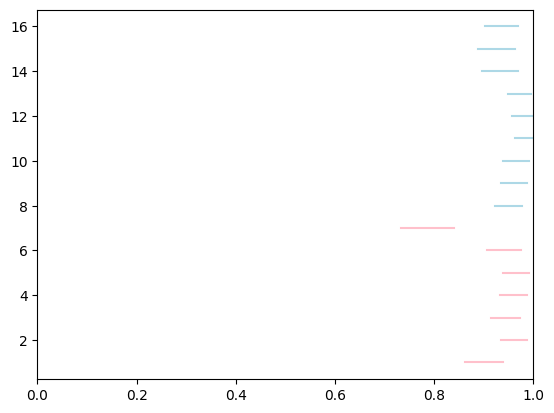

In [34]:
from collections import Counter
import statistics
import math
import matplotlib.pyplot as plt

def binary_ci(success, total, alpha=0.95):
    """
    Using Agresti-Coull interval
    
    Return mean and confidence interval (lower and upper bound)
    """
    z = statistics.NormalDist().inv_cdf((1 + alpha) / 2)
    total = total + z**2
    loc = (success + (z**2) / 2) / total
    diameter = z * math.sqrt(loc * (1 - loc) / total)
    return loc, loc - diameter, loc + diameter 

for translator in (chatgpt,):
    buf = []
    for sentence, stereotype in zip(sentences, stereotypes):
        buf.append((stereotype, heuristic(sentence, translator)))
    print(sum(x[1] in ('male', 'female') for x in buf))
    c = Counter(buf)
    for i in range(1, 17):
        _, l, u = binary_ci(c[i, 'male'], c[i, 'male'] + c[i, 'female'])
        plt.plot([l, u], [i, i], c='pink' if i < 8 else 'lightblue')
    plt.xlim(0, 1)
    plt.show()

3359


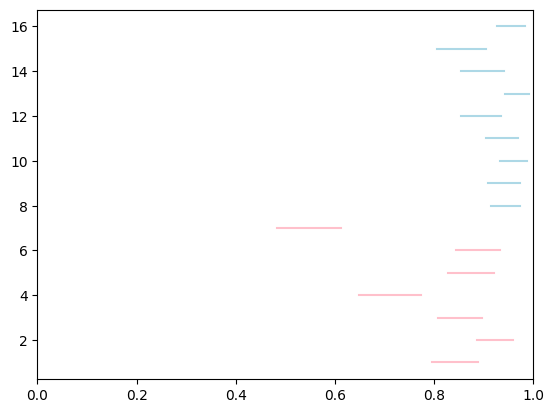

3383


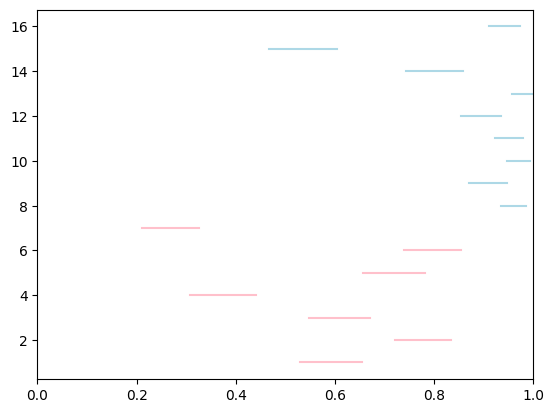

3343


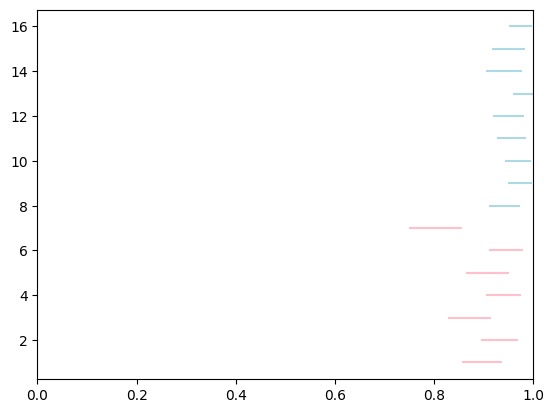

In [102]:
from collections import Counter
import statistics
import math
import matplotlib.pyplot as plt

def binary_ci(success, total, alpha=0.95):
    """
    Using Agresti-Coull interval
    
    Return mean and confidence interval (lower and upper bound)
    """
    z = statistics.NormalDist().inv_cdf((1 + alpha) / 2)
    total = total + z**2
    loc = (success + (z**2) / 2) / total
    diameter = z * math.sqrt(loc * (1 - loc) / total)
    return loc, loc - diameter, loc + diameter 

for translator in (google_translate, deepl, amazon_translate):
    buf = []
    for sentence, stereotype in zip(sentences, stereotypes):
        buf.append((stereotype, heuristic(sentence, translator)))
    print(sum(x[1] in ('male', 'female') for x in buf))
    c = Counter(buf)
    for i in range(1, 17):
        _, l, u = binary_ci(c[i, 'male'], c[i, 'male'] + c[i, 'female'])
        plt.plot([l, u], [i, i], c='pink' if i < 8 else 'lightblue')
    plt.xlim(0, 1)
    plt.show()

## Tematic bias

The most common words for male words that are misclassifed as female often have _female_-related words in them.

In [125]:
c = Counter()

for sentence, stereotype in zip(sentences, stereotypes):
    if stereotype > 7 and stereotype != 15 and any(heuristic(sentence, translator) == 'female' for translator in translators):
        sentence = sentence.replace(',', '').replace('.', '')
        c.update(sentence.split())

# for sentence, stereotype in zip(sentences, stereotypes):
#     if stereotype < 8 and any(heuristic(sentence, translator) == 'male' for translator in translators):
#         sentence = sentence.replace(',', '').replace('.', '')
#         c.update(sentence.split())

stopwords = open('stopwords.txt').read().splitlines()
for word, count in c.most_common(100):
    if word.lower().strip('.') not in stopwords:
        print(word, count)

partner 11
job 10
care 9
emotions 8
lot 8
kids 7
children 7
confidence 7
family 6
money 5
feel 5
time 5
signed 4
family's 4
happy 4
handle 4
hard 4
saved 4
life 4


## Generating data for heuristic evaluation

In [93]:
from collections import defaultdict

rated = defaultdict(lambda: list())

for sentence in sentences:
    for translator in translators:
        rated[heuristic(sentence, translator)].append((sentence, translator))

(
    len(rated),
    len(rated['male']),
    len(rated['female']),
    len(rated[None]),
)

(3, 8658, 1427, 958)

In [95]:
import random

for k, v in rated.items():
    sample = random.sample(v, 100)
    for sentence, translator in sample:
        print(sentence)
        print(gender_translate(sentence, translator, 'default'))
        print(*(h(sentence, translator) for h in list_of_heuristics))
        print()

I never ignored any rules.
Nikdy som neignoroval žiadne pravidlá.
male None None None None

I went there and immediately made new friends.
Išiel som tam a hneď som si našiel nových priateľov.
male None None male None

I have studied Japanese customs because I have dealings with the Japanese ambassador.
Študoval som japonské zvyky, pretože mám dočinenia s japonským veľvyslancom.
male None None male None

I created and maintained an emergency fund to provide a safety net for unexpected expenses.
Vytvoril a udržiaval som núdzový fond, aby som si vytvoril záchrannú sieť pre prípad neočakávaných výdavkov.
male None None None None

I traveled a lot so I know which tickets you need to buy.
Veľa som cestoval, takže viem, ktoré lístky si musíte kúpiť.
male None None male None

I've made it a tradition that every Christmas I buy a gift at one of the benefit stores.
Urobil som si tradíciu, že každé Vianoce kúpim darček v niektorom z benefičných obchodov.
male None None male None

I'm rational whe

## Parsing

In [31]:
import json
import os

from tqdm import tqdm
from trankit import Pipeline

class PosParser:

    file_path = os.path.join('cache', 'parser', 'results.json')

    def __init__(self):
        self.pipeline = Pipeline('slovak')
        # pipeline = Pipeline('slovak', embedding='xlm-roberta-large')
        
        if os.path.exists(self.file_path):
            with open(self.file_path, 'r') as json_file:
                self.dict = json.load(json_file)
        else:
            self.dict = {}

    
    def parse(self, texts):
        for text in tqdm(texts):
            if text not in self.dict:
                parse = self.pipeline.posdep(text)
                self.dict[text] = parse

        self.save()

        return {
            text: self.dict[text]
            for text in texts
        }

    
    def save(self):
        with open(self.file_path, 'w') as json_file:
            json.dump(self.dict, json_file)

parser = PosParser()

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:trankit.adapter_transformers.file_utils:PyTorch version 2.0.1+cu117 available.
INFO:trankit.adapter_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-sentencepiece.bpe.model from cache at cache/trankit/xlm-roberta-base/0c370616ddfc06067c0634160f749c2cf9d8da2c50e03a2617ce5841c8df3b1d.309f0c29486cffc28e1e40a2ab0ac8f500c203fe080b95f820aa9cb58e5b84ed


Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for slovak
Loading tagger for slovak
Loading lemmatizer for slovak
Active language: slovak


In [ ]:
all_sentences = set(
    gender_translate(s, t, g)
    for t in (google_translate, amazon_translate, chatgpt, deepl)
    for g in ('default', 'male', 'female')
    for s in sentences
)
all_sentences -= {None}
print(len(all_sentences))

In [ ]:
for x in range(300):
    print(x)
    subset = list(all_sentences)[x*100 : x*100+100]
    parser.parse(subset)